# LSTM para predecir S&P 500

Machine Learning Avanzado

>  Thamara Lopez, Fabián Ortega

In [19]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import seaborn as sns
import datetime as dt
from datetime import datetime

Utilizamos los datos de Cierre ajustado del S&P500, además de tomar como feature el Volumen y el VIX. 

In [41]:
dataset_train = pd.read_csv("../data/training_data.csv")
dataset_train.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,d_volatility,VIX
1242,2021-12-08,4690.859863,4705.060059,4674.520020,4701.209961,4701.209961,3061550000,0.006511,19.90
1243,2021-12-09,4691.000000,4695.259766,4665.979980,4667.450195,4667.450195,2851660000,0.006242,21.58
1244,2021-12-10,4687.640137,4713.569824,4670.240234,4712.020020,4712.020020,2858310000,0.009243,18.69
1245,2021-12-13,4710.299805,4710.299805,4667.600098,4668.970215,4668.970215,3322050000,0.009065,20.31
1246,2021-12-14,4642.990234,4660.470215,4606.520020,4634.089844,4634.089844,3292740000,0.011620,21.89


## Análisis Exploratorio de los datos

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

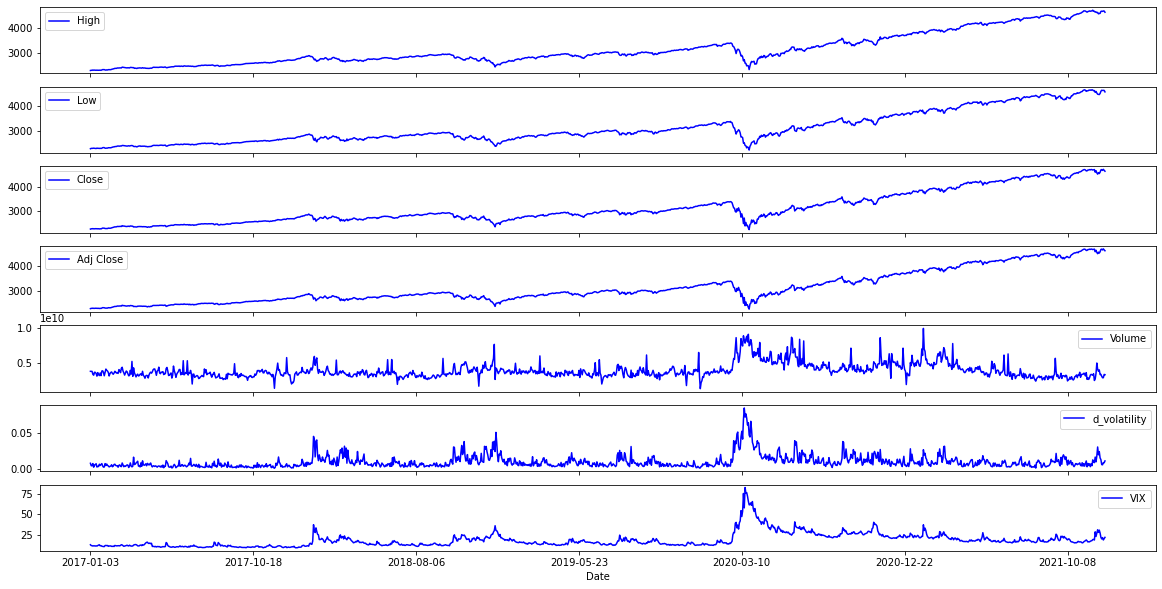

In [42]:
dataset_train.set_index('Date').iloc[:,1:8].plot(subplots=True, color='blue', figsize=(20,10))

In [21]:
dataset_train = dataset_train[['Date', "Adj Close", "Volume","VIX"]]

In [23]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:4]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1247, 4)
All timestamps == 1247
Featured selected: ['Adj Close', 'Volume', 'VIX']


Preprocesamiento

In [24]:
dataset_train = dataset_train[cols]
dataset_train = dataset_train.astype(float)
# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1247, 3).


array([[2.25783008e+03, 3.77053000e+09, 1.28500000e+01],
       [2.27075000e+03, 3.76489000e+09, 1.18500000e+01],
       [2.26900000e+03, 3.76182000e+09, 1.16700000e+01],
       ...,
       [4.71202002e+03, 2.85831000e+09, 1.86900000e+01],
       [4.66897021e+03, 3.32205000e+09, 2.03100000e+01],
       [4.63408984e+03, 3.29274000e+09, 2.18900000e+01]])

In [25]:
# Feature Scaling
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])  #Y

array([[-1.30859   ],
       [-1.28864641],
       [-1.29134777],
       ...,
       [ 2.47977171],
       [ 2.41331873],
       [ 2.35947633]])

In [34]:
# Dataframe para 16 fechas 1 un output
X_train = []
y_train = []

n_future = 16   # Number of days we want top predict into the future
n_past = 80    # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1152, 80, 2).
y_train shape == (1152, 1).


# Modelo LSTM

In [35]:
def modelo_lstm(trainX,trainY,neuronas, capas, epocas, batch_size,validation_split):

    csv_logger = tf.keras.callbacks.CSVLogger('training.log', separator=',', append=False)

    model = tf.keras.models.Sequential()
    #Entrada
    model.add(tf.keras.layers.LSTM(neuronas ,activation='tanh', input_shape=(n_past, dataset_train.shape[1]-1), return_sequences=True))
    # regularizacion en las conexiones de entrada
    model.add(tf.keras.layers.Dropout(0.2)) 
   
    #second LSTM
    for i in range(capas):
        model.add(tf.keras.layers.LSTM(units=32, return_sequences = False))
        model.add(tf.keras.layers.Dropout(0.2)) 
    
   
    # Salida
    model.add(tf.keras.layers.Dense(trainY.shape[1], activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01) , loss="mean_squared_error")
    model.summary()

    #definir "early stopping" la loss de validacion no mejora en X épocas
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=50,  #numero de epocas sin mejora
                                                      restore_best_weights = True)
    tb = tf.keras.callbacks.TensorBoard('logs')
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, verbose=1)
    mcp = tf.keras.callbacks.ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    history = model.fit(trainX, trainY,epochs=epocas, batch_size=batch_size, validation_split=validation_split, verbose=1, callbacks=[early_stopping, csv_logger, tb, rlr, mcp])

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.ylabel("Error")
    plt.xlabel("Epocas")
    plt.legend()
    return model
    

# Entrenamiento

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 80, 64)            17152     
                                                                 
 dropout_6 (Dropout)         (None, 80, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2022-01-27 17:09:42.272872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 17:09:42.536418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 17:09:42.721451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 17:09:42.893908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 17:09:43.147868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - ETA: 0s - loss: 0.2297

2022-01-27 17:09:47.319398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 17:09:47.389531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 17:09:47.499353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.29520, saving model to weights.h5
65/65 [==============================] - 7s 74ms/step - loss: 0.2297 - val_loss: 0.2952 - lr: 0.0100
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.2186
Epoch 00002: val_loss did not improve from 0.29520
65/65 [==============================] - 3s 47ms/step - loss: 0.2186 - val_loss: 0.7354 - lr: 0.0100
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.2482
Epoch 00003: val_loss did not improve from 0.29520
65/65 [==============================] - 3s 47ms/step - loss: 0.2482 - val_loss: 1.4967 - lr: 0.0100
Epoch 4/200
65/65 [==============================] - ETA: 0s - loss: 0.2132
Epoch 00004: val_loss did not improve from 0.29520
65/65 [==============================] - 3s 46ms/step - loss: 0.2132 - val_loss: 1.1485 - lr: 0.0100
Epoch 5/200
65/65 [==============================] - ETA: 0s - loss: 0.2238
Epoch 00005: val_loss did not improve from 0.29520
65/65 [=

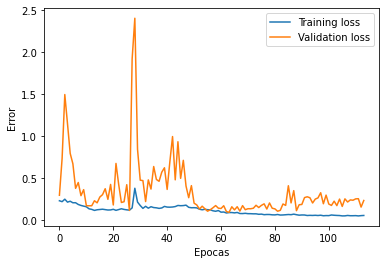

In [36]:
modelo = modelo_lstm(X_train, y_train, 64, capas=1,epocas=200, batch_size=16,validation_split=0.1)

# Forecasting

In [37]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [38]:
# Perform predictions
predictions_future = modelo.predict(X_train[-n_future:])

predictions_train = modelo.predict(X_train[n_past:])

2022-01-27 17:15:49.710275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 17:15:49.779842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 17:15:49.941947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [39]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Adj Close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Adj Close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN


PREDICTIONS_FUTURE.index = PREDICTIONS_FUTURE.index.to_series().apply(datetime_to_timestamp)

PREDICTIONS_FUTURE.head(3)

,Adj Close
2021-12-14,4622.539551
2021-12-15,4641.930176
2021-12-16,4602.145020


Export para binnario

Las fechas no corresponden, pero si el número de observaciones. 

In [47]:
df_to_binnario = PREDICTIONS_FUTURE[1:]
df_to_binnario.to_csv("../output/preditct.csv",index=False, header= False)

# Estimación usando Prophet 

In [ ]:
import prophet